# Wetland water depth outputs<img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook. A csv file containing the daily maximum water discharge of a relevant stream gauge is also required. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal.

## Background
The Commonwealth Environmental Water Office (CEWO) is obliged to act in accordance with the Water Act and the Basin Plan.  This requires Basin water resources to be managed in a way that gives effect to relevant international agreements (to the extent to which those agreements are relevant to the use and management of the Basin water resources). The Basin Plan has a specific objective to protect and restore a subset of all water-dependent ecosystems of the Murray-Darling Bain including by ensuring that: 
* Declared Ramsar wetlands that depend on Basin water resources maintain their ecological character. 

## Description
This notebook produces the following deliverables for each Ramsar site for each 10 year time period: 

* Maps in the form of .jpg, polygons and rasters showing: (these maps should also include key vegetation types, including open water, as provided by the CEWO and also the Ramsar site boundary.)
    1. Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types. 
    2. Inundation extent for each vegetation type for each event (an event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry) across the period event for critical durations (1, 3, 5, 7, >9 months)(these inundation extents are critical for different types of vegetation) 
        * Derived from remote sensing <img align='right' src="./InputData/TOR-AttachmentA.png" style="width: 400px;"/>
        2.a. Comparison of remotely sensed data with ground-truthed data and OEH datasets (NSW only). 
    3. Maps of depth for critical durations, only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)  
    4. Vegetation condition over the entire four year period. 
5. Graph and .csv file of inundation duration for each different vegetation type, for all natural and environmental flows, as per image to the right
6. Table identifying: 
    * % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.
    * Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 
e.g. 

| Site | Sub-site | Decade | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|
|Banrock Station | | |River redgum | | | | | | |
| | | |Black box | | | | | | |
| | | |Lignum| | | | | | |
| | | |Saltmarsh| | | | | | |
| | | |Tall emergent aquatics| | | | | | |
| | | |Grass/forb | | | | | | |


7. Annual vegetation condition for each Ramsar site for the whole archive period
***

## Code assumptions

A few assumptions and decisions were made within the code that affect the outcome of the results:
1. Maps of inundation extent across the time period 2014-2019
2. Maps of inundation extent for each vegetation type for each event
    a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 
3. Maps of depth for critical durations
4. Vegetation condition over the entire four year period
5. Graph and .csv file of inundation duration for each different vegetation type
6. Table identifying % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation and Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type
    - Events were defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. 
    - If the first time a wetland is observed by Landsat 5 (1986/7), the wetland meets the event threshold, we choose NOT to include this event in the list of events
        - We don't know how long the wetland was wet before we first observed it, and so can't provide uncertainties on event duration, so we do not include it in the results
    - For analysis of inundation WITHIN an event, we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). e.g. If a pixel has a within event inundation history of 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 
    - We use days to define the requested metric periods, so 1 month = 30 days, 3 months = 90 days etc.
    - Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 
    - Results for the duration of different percentages of inundation are presented in days. 
7. Annual vegetation condition for each Ramsar site for the whole archive period

## (Progress tracking)

| Wetland | LiDAR DEM | Vegetation shapefile | NetCDF created? | 
|---------|-----------|----------------------|-----------------|
| Narran Lake | <ul><li>Data are a combination of [GA's aggregated 5m DEM product](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644), and NSW Spatial Services 5m DEM scenes from the couple of bits of the eastern edge of the Ramsar polygon that are cut out of the GA product</li><li>The combination happened by clipping the GA and required additional NSW scenes to the extent of the Ramsar polygon.</li><li> These were then merged together using the `mosaic` tool in ArcGIS, where the GA scene was given preference over the NSW scenes where data existed in both</li></ul>  | `VegShapeFileVegNameColumn = 'AggCOMM'` `VegShapeFileVegNameUIDColumn = None` | Yes |

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import sys
import glob
import itertools
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features, transform
import geopandas as gpd
from shapely.geometry import shape as shapelyshape

import pickle
import warnings
warnings.simplefilter("ignore")

In [2]:
def get_water_level(geom, dem, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and uncertainty) based on the same DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.exterior.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:
        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        
        # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        #all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))
        all_offsets.append(((x_offset, y_offset, np.percentile(sampled_elevs, 90), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]

    return offset_min_std 

def consecutiveGroup(L):
    '''
    From here https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list
    '''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

### Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.
* `StreamGaugeName`: A string name of the stream gauge used in the analysis, used to label graphs.
* `OutSaveLocation`: A string folder structure for the location of files written out by the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook, and this notebook. It makes use of the `AnalysisLocation` string to generate the filepath.

#### Files to analyse
* `DatasetToLoad`: The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.
* `SpeciesDictToLoad`: The filename of the text file written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) that contains the species dictionary of vegetation type and numerical ID. This is used to label plots.
* `StreamGaugeToLoad`: The filename of a csv file containing the daily maximum water discharge of a relevant stream gauge. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal. The code below assumes that commented lines begin with `#`. 

#### Analysis options
* `EventThreshold`: e.g. 5. Used to determine the threshold for starting/ending a watering event. Watering events are defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. If the wetland completely dries out between events, set this threshold low e.g. 5. If the wetland contains refugial pools that rarely dry out, a wet event may need to be defined using a higher threshold. 
* `AreasToCalc`: e.g. [0.1, 0.25, 0.50, 0.75, 0.100]. A list of numbers of the decimal vegetation area thresholds to calculate. E.g. 0.1 will calculate a value for 10% of the vegetation area. These are used in section 6 below.
* `Colormaps`: e.g. ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds']. A list of [Matplotlib named colormaps](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) to use to plot the different vegetation communities. 

#### Output filenames

##### Section 2
* `EventMapsFileName` : e.g. string. File path for the output plots for each wet event. The complete file path is created in the code below, since it adds in the event dates as it plots. 

##### Section 5
* `InundationPctPerVegFigFileName`: e.g. string.jpg Output file name for the all time vegetation community based inundation plot.
* `InundationPctPerVegDataFileName`: e.g. string.csv Output file name for the all time vegetation community based inundation csv.

##### Section 6
* `EventListFileName`: e.g. string.csv Output file name for the start and end dates and duration of each defined watering event.
* `EventInundationTableFileName`: e.g. string.csv Output file name for the event-based inundation % metrics for each vegetation community.
* `EventDurationTableFileName` : e.g. string.csv Output file name for the event-based duration metrics for each vegetation community.

In [3]:
# Note, if your `AnalysisLocation` contains special characters other than spaces, you will
# need to modify the `replace` function used to generate the output file names.
AnalysisLocation = 'Narran Lake'
StreamGaugeName = 'Wilby Wilby'
OutSaveLocation = f'OutputData/{AnalysisLocation.replace(" ", "")}/'

DatasetToLoad = f'{OutSaveLocation}AllDataCombined{AnalysisLocation.replace(" ", "")}.nc'
HighResDatasetToLoad = LidarVegOutputName = f'{OutSaveLocation}LiDARVeg{AnalysisLocation.replace(" ", "")}.nc'
SpeciesDictToLoad = f'{OutSaveLocation}SpeciesDict{AnalysisLocation.replace(" ", "")}.txt'
StreamGaugeToLoad = 'InputData/NarranLake/Narran_WilbyWilby_422016DailyMax.csv'
RamsarBoundaryFile = 'InputData/NarranLake/NarranRamsarBoundary.shp'

EventThreshold = 5
AreasToCalc = [0.1, 0.25, 0.50, 0.75, 1]
Colormaps = ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds', 'Greys']

# Depth netCDF output file name
WetlandWaterDepthsFileName = f'{OutSaveLocation}WetlandWaterDepths{AnalysisLocation.replace(" ", "")}.nc'

# Outputs for section 2
EventMapsFileName = f'{OutSaveLocation}EventMaps/{AnalysisLocation}Event' # Name completed and appended in the script below

# Outputs for section 5
InundationPctPerVegFigFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.jpg'
InundationPctPerVegDataFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.csv'
# Outputs for section 6
EventListFileName = f'{OutSaveLocation}WetEventsIn{AnalysisLocation.replace(" ", "")}With{str(EventThreshold)}%AreaThreshold.csv'
EventInundationTableFileName = f'{OutSaveLocation}EventInundationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventDurationTableFileName = f'{OutSaveLocation}EventDurationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventResultsPickleFileName = f'{OutSaveLocation}EventResults/' # Name completed and appended in the script below

## Load in our pre-analysed datasets

### Starting with our giant all together netCDF

In [4]:
AllDataCombined = xr.open_dataset(DatasetToLoad)

We need to create a transform object from our dataset so that we can do some of the code calculations later on.

In [5]:
AllDataCombined.attrs['transform'] = transform.from_bounds(AllDataCombined.x.min().item(),
                                                           AllDataCombined.y.min().item(), 
                                                           AllDataCombined.x.max().item(), 
                                                           AllDataCombined.y.max().item(),
                                                           len(AllDataCombined.x),
                                                           len(AllDataCombined.y)
                                                          )

In [6]:
AllDataCombined

<xarray.Dataset>
Dimensions:        (time: 1200, x: 549, y: 541)
Coordinates:
  * x              (x) float64 1.465e+06 1.465e+06 ... 1.479e+06 1.479e+06
  * y              (y) float64 -3.315e+06 -3.315e+06 ... -3.328e+06 -3.328e+06
    spatial_ref    int32 ...
  * time           (time) datetime64[ns] 1986-08-19T23:28:42.692285 ... 2019-08-22T23:54:07.640074952
Data variables:
    nbart_red      (time, y, x) float32 ...
    nbart_blue     (time, y, x) float32 ...
    nbart_green    (time, y, x) float32 ...
    nbart_nir      (time, y, x) float32 ...
    nbart_swir_1   (time, y, x) float32 ...
    nbart_swir_2   (time, y, x) float32 ...
    TCW            (time, y, x) float32 ...
    product        (time, y, x) object ...
    wet            (time, y, x) float32 ...
    wetCount       (time, y, x) int8 ...
    wetFreq        (y, x) float64 ...
    wetFreqPct     (y, x) float64 ...
    justwetHAND    (y, x, time) float64 ...
    veg_randomUID  (y, x) float64 ...
    HAND           (y, x) float64 ...
    DEM            (y, x) float32 ...
    DEMCorr        (y, x) float64 ...
    DEMDir         (y, x) float64 ...
    DEMAcc         (y, x) float64 ...
Attributes:
    crs:           +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0...
    grid_mapping:  spatial_ref
    transform:     | 24.95, 0.00, 1465437.50|\n| 0.00,-24.95,-3314662.50|\n| ...

### Load in the high res version of the LiDAR data

In [7]:
HighResLidar = xr.open_dataset(HighResDatasetToLoad)

In [8]:
HighResLidar.attrs['transform'] = transform.from_bounds(HighResLidar.x.min().item(),
                                                           HighResLidar.y.min().item(), 
                                                           HighResLidar.x.max().item(), 
                                                           HighResLidar.y.max().item(),
                                                           len(HighResLidar.x),
                                                           len(HighResLidar.y)
                                                          )

### We also need to load in the species dictionary we saved out

In [9]:
with open(SpeciesDictToLoad, 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

#### We need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [10]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [11]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    # Check how long the veg name is and if it's longer than 20 char, shorten.
    if len(VegName) > 20:
        XTickNames.append(VegName[:20])
    else:
        XTickNames.append(VegName)

### Read in the Ramsar boundary shapefile

In [12]:
RamsarBoundary = gpd.read_file(RamsarBoundaryFile)
RamsarBoundary = RamsarBoundary.to_crs(AllDataCombined.crs)

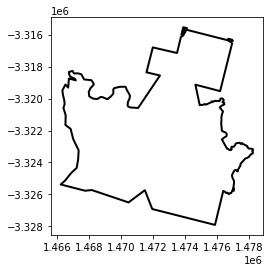

In [13]:
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2);

## Calculate the water level for each inundated area across all time

### Create an empty data array to put our inundation results in to

In [8]:
WetlandWaterDepths = HighResLidar['DEM'].copy()
WetlandWaterDepths[:] = np.nan
WetlandWaterDepths = WetlandWaterDepths.expand_dims({'time': AllDataCombined.time}).copy()
#WetlandWaterDepths = WetlandWaterDepths.expand_dims({'time': AllDataCombined.time.isel(time=range(0,20))}).copy()

### Loop through each time step and calculate the water inundation height

In [9]:
# Loop through each time step
for ix in range(14, len(WetlandWaterDepths.time)):
    # print out an update every 50 timesteps
    if ix/50 == int(ix/50):
        print(f'Working on {WetlandWaterDepths.time[ix].data}')
    # Interpolate the satellite data onto the grid of the Lidar
    WetonLidar = AllDataCombined['wet'].isel(time=ix).interp(x = HighResLidar.x, y= HighResLidar.y, method='nearest')
    # Convert to a boolean wet/not wet
    WetonLidar = np.isfinite(WetonLidar)
    # Check for a completely dry timestep. If it is completely dry, ignore it.
    if WetonLidar.sum() > 0:
        # Polygonize the wet bits in the timestep to turn them into polygons
        WetPolygons = features.shapes(WetonLidar.data.astype('float32'),
                                      transform=HighResLidar.attrs['transform'],
                                     connectivity=8)
        # Convert polygons into a geodataframe
        DiscreteWetPolygons = gpd.GeoDataFrame(WetPolygons, columns =['stringgeom', 'wetyes'])
        # Fix up the geometry attribute
        DiscreteWetPolygons['geometry'] = None
        for idx, poly in DiscreteWetPolygons.iterrows():
            DiscreteWetPolygons.loc[idx,'geometry'] = shapelyshape(poly[0])
        # Set the geometry of the dataframe to be the shapely geometry we just created
        DiscreteWetPolygons = DiscreteWetPolygons.set_geometry('geometry')
        # We need to add the crs back onto the dataframe
        DiscreteWetPolygons.crs = 'EPSG:3577'
        # Drop the nan polygon created from the nan values
        DiscreteWetPolygons = DiscreteWetPolygons.loc[DiscreteWetPolygons['wetyes'] == 1]
        # And drop the temporary stringgeom
        DiscreteWetPolygons.drop('stringgeom', axis=1, inplace=True)
        
        # Now loop through each polygon shape to calculate a water surface height
        for shapez in DiscreteWetPolygons.iterrows():
            # Sample the LiDAR array that intersects with the outline of each wet polygon
            # then create a 2D interpolated smooth surface from the DEM values to simulate water inundating it
            EstWaterLevel = get_water_level(shapez[1]['geometry'], HighResLidar.DEM)
            # Subtract 
            EstWaterHeight = EstWaterLevel['water_level'] - HighResLidar.DEM
            EstWaterHeight.attrs['transform'] = HighResLidar.attrs['transform']
            y, x = HighResLidar.DEM.values.shape
            # Now convert the polgons into a numpy array
            RasterWetPoly = features.rasterize(shapes=shapez[1],
                                                    out_shape=(y, x),
                                                    all_touched=False,
                                                    fill=np.nan,
                                                    transform=HighResLidar.attrs['transform'])
            # Convert result to a xarray.DataArray using coords etc from the LiDAR data
            RasterWetPoly = xr.DataArray(RasterWetPoly,
                                     coords=[HighResLidar.y, HighResLidar.x],
                                     dims=['y', 'x'],
                                     name='wetBits',
                                     attrs=HighResLidar.attrs)
            WaterBodyHeight = EstWaterHeight.where((RasterWetPoly == 1) & (EstWaterHeight >= 0))
            WetlandWaterDepths.loc[{'time': WetlandWaterDepths['time'][ix]}] = xr.where(np.isfinite(WaterBodyHeight), WaterBodyHeight, 
                                                                          WetlandWaterDepths.loc[{'time': WetlandWaterDepths['time'][ix]}])
        if ix == 14:
            break

In [11]:
WetlandWaterDepths.to_netcdf(WetlandWaterDepthsFileName)

### Compare the depth results with the Landsat wet obs

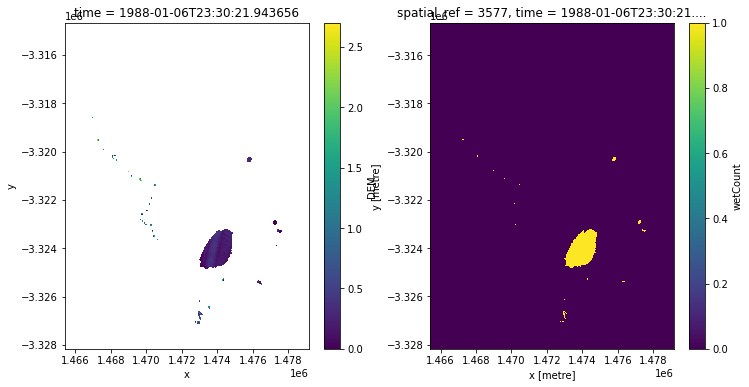

In [10]:
indx = 14
fig, ax = plt.subplots(1,2, figsize=[12, 6]);
WetlandWaterDepths.isel(time=indx).plot(ax=ax[0]);
AllDataCombined['wetCount'].isel(time=indx).plot(ax=ax[1]);

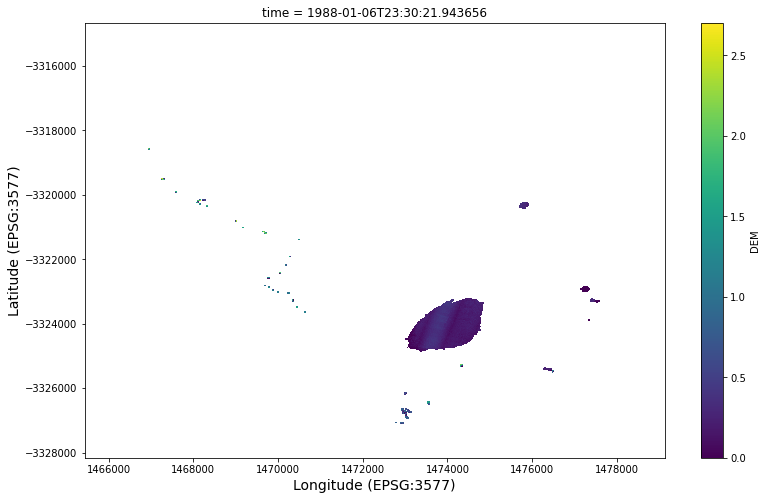

In [45]:
fig, ax = plt.subplots(1,1, figsize=[13, 8]);
#HighResLidar.DEM.plot(cmap='plasma', vmax=123, alpha = 0.6);
#AllDataCombined['wet'].isel(time=indx).plot(cmap='Blues')
#DiscreteWetPolygons.plot(color='None', edgecolor='k', linewidth = 2, ax=ax);
WetlandWaterDepths.isel(time=indx).plot()
plt.ticklabel_format(useOffset=False, style='plain');
plt.xlabel('Longitude (EPSG:3577)', fontsize=14);
plt.ylabel('Latitude (EPSG:3577)', fontsize=14);

## Break up the vegetation data into discrete communities

While we can subset our area of interest according to vegetation type, there is likely to be a spatial component to the inundation characteristics of different sub communities within a vegetation class. 

We therefore polygonise the vegetation data (you could just read in the original polygon shapefile, but since the data are already here and mapped to Landsat pixels, we'll polygonise the raster), and remove any very small vegetation communites (smaller than 10 landsat pixels). These different polygons will allow us to explore the spatial heterogeneities in the vegetation wetness characteristics. 

In [15]:
VegPolygons = features.shapes(AllDataCombined['veg_randomUID'].data.astype('float32'),
                              transform=AllDataCombined.attrs['transform'])

DiscreteVegPolygons = gpd.GeoDataFrame(VegPolygons, columns =['stringgeom', 'vegUID'])

DiscreteVegPolygons['geometry'] = None
for ix, poly in DiscreteVegPolygons.iterrows():
    DiscreteVegPolygons.loc[ix,'geometry'] = shapelyshape(poly[0])
    
# Set the geometry of the dataframe to be the shapely geometry we just created
DiscreteVegPolygons = DiscreteVegPolygons.set_geometry('geometry')
# We need to add the crs back onto the dataframe
DiscreteVegPolygons.crs = 'EPSG:3577'

# Drop the nan polygon created from the nan values
DiscreteVegPolygons = DiscreteVegPolygons.loc[~np.isnan(DiscreteVegPolygons['vegUID'])]

# And drop the stringgeom
DiscreteVegPolygons.drop('stringgeom', axis=1, inplace=True)

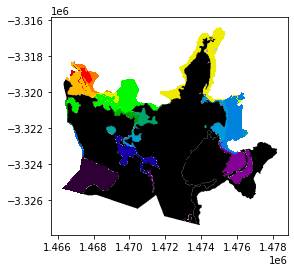

In [16]:
DiscreteVegPolygons.plot(cmap='nipy_spectral_r');

### Drop small vegetation polygons

We want to limit the number of small polygons in the analysis, so we calculate the area of each polygon and drop polygons smaller than 10 Landsat pixels `(25 * 25 * 10) = 6250`. 

In [17]:
DiscreteVegPolygons['area'] = DiscreteVegPolygons['geometry'].area

In [18]:
# Drop small polygons
print(f'Number of original polygons = {len(DiscreteVegPolygons)}')
DiscreteBiggerVegPolygons = DiscreteVegPolygons.loc[DiscreteVegPolygons['area'] >= 6250].reset_index()
print(f'Number of filtered polygons = {len(DiscreteBiggerVegPolygons)}')

Number of original polygons = 333
Number of filtered polygons = 57


## Identify 'events' within the wetland

Here an 'event' starts when `EventThreshold`% of the total wetland area seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. 

In [73]:
# Count the wet pixels per time step, and find where at least 5% of the wetland is 'wet'
ThresholdBooleanPctTimestepWet = AllDataCombined['wetCount'].sum(dim=['x', 'y']) > (np.isfinite(AllDataCombined['TCW']).sum(dim=['x', 'y']) / 100 * EventThreshold)

In [49]:
ThresholdBooleanPctTimestepWet

<xarray.DataArray (time: 1200)>
array([False, False, False, ..., False, False, False])
Coordinates:
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 1986-08-19T23:28:42.692285 ... 2019-08-22T23:54:07.640074952

Find where the wetland switches above/below `EventThreshold`% inundation. We can do this by looking for changes in the boolean operators

In [74]:
# Subtract subsequent value from first value
Testforchange = ThresholdBooleanPctTimestepWet[1:].values.astype(int) - ThresholdBooleanPctTimestepWet[:-1].values.astype(int)
# if it equals 1, then the array has moved from False to True
StartofEvent = ThresholdBooleanPctTimestepWet[1:].where(Testforchange == 1).dropna(dim='time')
# if it equals -1, then the array has moved from True to False
EndofEvent = ThresholdBooleanPctTimestepWet[1:].where(Testforchange == -1).dropna(dim='time')

### Check whether the wetland was wet when it was first observed (1986/7), and when it was last observed (most recent observation)

If the first time a wetland is observed by Landsat 5 (1986/7), the wetland meets the event threshold, we choose NOT to include this event in the list of events. We don't know for how long the wetland was wet before we first observed it, and so can't provide uncertainties on event duration, so we do not include it in the results.

If the wetland has been wet up until the most recent observation, we DO include this event, and for the sake of calculating the event duration, we set the most recent observation as the end date. This will change as the code is run over new data and eventually the event will be observed to end itself.

In [75]:
# We need to check whether the wetland is first observed during a wet event. 
# If it is, then the first value we actually find is an end date, which throws off our calculation.
if ThresholdBooleanPctTimestepWet[0] == 1:
    # Skip the first EndofEvent, since we didn't capture the start and so can't say 
    EndofEvent = EndofEvent[1:]

# Also need to check if we've captured the end of the event properly
# If the event ends with a wet observation, we wont capture this in the code below
# Because we know that time -1 of this event is the end of the wetland-wide event,
# we can just add time -1 as the last end date.
if ThresholdBooleanPctTimestepWet[-1] == 1:
    # Then the event wont 'end' since it wont have flipped
    EndofEvent = np.hstack((AnyPartWet[-1], EndofEvent))

Make use of pandas datetime operators to calculate the length of time between each start and end date. 

In [76]:
# Now calculate the length of time between the inundation events within the overall wetland event
# Code notation notes:
#`astype('timedelta64[D]')` converts the timedelta from `ns` to `days`. 
#`/ np.timedelta64(1, 'D')` removes the timedelta information and just returns the number of days as a float.
EventDuration = (EndofEvent.time.values - StartofEvent.time.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')

Convert the results into a dataframe so we can export to csv

In [77]:
EventList = pd.DataFrame(EventDuration.astype(int),  
                         columns = ['days-in-event'])
EventList['event-start-date'] = StartofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)
EventList['event-end-date'] = EndofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)
EventList

,days-in-event,event-start-date,event-end-date
0,288,1988-03-10,1988-12-23
1,8,1988-12-30,1989-01-08
2,319,1989-04-30,1990-03-16
3,207,1990-05-03,1990-11-27
4,112,1991-03-03,1991-06-23
5,24,1993-12-28,1994-01-22
6,175,1994-03-11,1994-09-03
7,39,1995-01-25,1995-03-05
8,336,1995-12-11,1996-11-11
9,8,1996-11-18,1996-11-27


### Find events < 30 days and double check it's not just a single scene that has dropped below the threshold

In [54]:
# Create an index list of rows to drop
RowsToDrop = []
# Find events that are less than 30 days long
ShortEvent = EventList['days-in-event'] < 30
# Get the indices of these short events
ShortEventIndex = EventList.index[ShortEvent == True].tolist()
# We need to see if there are consecutive short events - they may need to be all combined together
ConsecutiveIndices = [i for i in consecutiveGroup(ShortEventIndex) if i[0] != i[1]]
# Test whether we actually have any consecutive short events
if ConsecutiveIndices:
    # Get the full list of indices for the consecutive events
    ConsecutiveIndices = [list(range(i[0], i[1] + 1)) for i in ConsecutiveIndices]
    for consecEvent in ConsecutiveIndices:
        previousMerge = False
        nextMerge = False
        # Test whether these are actually consecutive events, or just short events months apart
        Starts = pd.to_datetime(EventList.loc[consecEvent]['event-start-date'])
        Ends = pd.to_datetime(EventList.loc[consecEvent]['event-end-date'])
        # remove the first start date
        Starts = Starts[1:]
        # Remove the last end date
        Ends = Ends[:-1]
        TimeBetweenEvents = (Starts.values - Ends.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')
        
        
        
        # Did this event start within 16 days of the previous event?
        if (pd.to_datetime(EventList.loc[consecEvent[0]]['event-start-date']) - pd.to_datetime(EventList.loc[consecEvent[0] -1]['event-end-date'])).days <= 16:
            previousMerge = True
        # Did this event finish within 16 days of the next event?
        if (pd.to_datetime(EventList.loc[consecEvent[-1] +1]['event-end-date']) - pd.to_datetime(EventList.loc[consecEvent[-1]]['event-start-date'])).days <= 16:
            nextMerge = True
        # So lets work out what we need to merge
        if previousMerge and nextMerge:
            EventStart = EventList.loc[consecEvent[0] -1]['event-start-date']
            EventEnd = EventList.loc[consecEvent[-1] +1]['event-end-date']
            EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
            # Drop the short event, plus the previous AND next events
            RowsToDrop.append(consecEvent[0] -1)
            RowsToDrop.extend(consecEvent)
            RowsToDrop.append(consecEvent[-1] +1)
            EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                             'event-start-date': EventStart,
                             'event-end-date': EventEnd},name=consecEvent[0]*1000))
        if previousMerge and not nextMerge:
            EventStart = EventList.loc[consecEvent[0] -1]['event-start-date']
            EventEnd = EventList.loc[consecEvent[-1]]['event-end-date']
            EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
            # Drop the short event, plus the previous AND next events
            RowsToDrop.append(consecEvent[0] -1)
            RowsToDrop.extend(consecEvent)
            EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                             'event-start-date': EventStart,
                             'event-end-date': EventEnd},name=consecEvent[0]*1000))
        if nextMerge and not previousMerge:
            EventStart = EventList.loc[consecEvent[0]]['event-start-date']
            EventEnd = EventList.loc[consecEvent[-1] + 1]['event-end-date']
            EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
            # Drop the short event, plus the previous AND next events
            RowsToDrop.append(consecEvent[-1])
            RowsToDrop.extend(consecEvent)
            EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                             'event-start-date': EventStart,
                             'event-end-date': EventEnd},name=consecEvent[0]*1000))
    ShortEventIndexNonSequential = [x for x in ShortEventIndex if x not in ConsecutiveIndices]
else:
    ShortEventIndexNonSequential = ShortEventIndex
for eventidx in ShortEventIndexNonSequential:
    ThisEvent = EventList.loc[eventidx]
    PreviousEvent = EventList.loc[eventidx - 1]
    NextEvent = EventList.loc[eventidx + 1]
    previousMerge = False
    nextMerge = False
    # Did this event start within 16 days of the previous event?
    if (pd.to_datetime(ThisEvent['event-start-date']) - pd.to_datetime(PreviousEvent['event-end-date'])).days <= 16:
        previousMerge = True
    # Did this event finish within 16 days of the next event?
    if (pd.to_datetime(NextEvent['event-start-date']) - pd.to_datetime(ThisEvent['event-end-date'])).days <= 16:
        nextMerge = True
    # So lets work out what we need to merge
    if previousMerge and nextMerge:
        EventStart = EventList.loc[eventidx - 1]['event-start-date']
        EventEnd = EventList.loc[eventidx + 1]['event-end-date']
        EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
        # Drop the short event, plus the previous AND next events
        RowsToDrop.append(eventidx - 1)
        RowsToDrop.append(eventidx)
        RowsToDrop.append(eventidx + 1)
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart,
                         'event-end-date': EventEnd},name=eventidx*1000))
    if previousMerge and not nextMerge:
        EventStart = EventList.loc[eventidx - 1]['event-start-date']
        EventEnd = EventList.loc[eventidx]['event-end-date']
        EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
        # Drop the short event, plus the previous AND next events
        RowsToDrop.append(eventidx - 1)
        RowsToDrop.append(eventidx)
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart,
                         'event-end-date': EventEnd},name=eventidx*1000))
    if nextMerge and not previousMerge:
        EventStart = EventList.loc[eventidx]['event-start-date']
        EventEnd = EventList.loc[eventidx + 1]['event-end-date']
        EventDuration = (pd.to_datetime(EventEnd) - pd.to_datetime(EventStart)).days
        # Drop the short event, plus the previous AND next events
        RowsToDrop.append(eventidx - 1)
        RowsToDrop.append(eventidx)
        EventList = EventList.append(pd.Series({'days-in-event': EventDuration,
                         'event-start-date': EventStart,
                         'event-end-date': EventEnd},name=eventidx*1000))
# Now drop all the rows we have modified
EventList.drop(set(RowsToDrop), inplace=True)
# And sort again by date, resetting the index
EventList.sort_values('event-start-date', ignore_index=True, inplace=True)

In [122]:
Starts = pd.to_datetime(EventList.loc[consecEvent]['event-start-date'])
Ends = pd.to_datetime(EventList.loc[consecEvent]['event-end-date'])
# remove the first start date
Starts = Starts[1:]
# Remove the last end date
Ends = Ends[:-1]
TimeBetweenEvents = (Starts.values - Ends.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')

In [127]:
consecEvent[TimeBetweenEvents < 16]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
EventList.to_csv(EventListFileName, index=False)

### Calculate the per event pixel inundation duration

Here, the analysis is done on a per event basis. This means that we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). 

The code below loops through each species type within the wetland, and calculates the percentage of that species' area that is inundated for more than 30, 90, 150, 210 and 270 days during the whole event. If a single pixel records a wetting history of e.g. 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 

The results for each vegetation community during each event is written out as a pickle file for use later on.

In [ ]:
# Loop through all the vegetation communities
for items in SpeciesDict:
    print(f'Working on {SpeciesDict[items]}')
    # Loop through all the individual wetting events
    for ix, row in EventList.iterrows():
        print(f'Working on event starting {row["event-start-date"]}')
        # Grab just the wet pixels that intersect with our veg type (boolean)
        JustOneVegTypeWet = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
        # Grab just the time slices that coincide with the event we're now analysing
        EventData = JustOneVegTypeWet.loc[slice(row['event-start-date'], row['event-end-date'])]
        # Make an empty array to put the event results in to
        EventResults = np.empty((len(AllDataCombined.y), len(AllDataCombined.x)))
        EventResults[:] = np.nan
        # Now loop through each pixel and work out how long it was inundated for during the event
        for x in range(len(EventData.x)):
            for y in range(len(EventData.y)):
                pixelArray=EventData[:,y,x]
                # test whether this pixel is just all NaN - if it is, we don't need to analyse it
                if pixelArray.sum() > 0:
                    # Subtract subsequent value from first value
                    Testforchange = pixelArray[1:].values.astype(int) - pixelArray[:-1].values.astype(int)
                    # if it equals 1, then the array has moved from False to True
                    StartofEvent = pixelArray[:-1].where(Testforchange == 1).dropna(dim='time')
                    # if it equals -1, then the array has moved from True to False
                    EndofEvent = pixelArray[1:].where(Testforchange == -1).dropna(dim='time')
                    # We need to check whether we've captured the start of the event properly
                    # If the event starts as wet at time zero, we wont capture this in the code below
                    # Because we know that time 0 of this event is the start of the wetland-wide event,
                    # we can just add time 0 as the first start date.
                    if pixelArray[0] == 1:
                        # Grab the first time step of the event and add it to the StartofEvent array
                        StartofEvent = np.hstack((pixelArray.time.values[0], StartofEvent.time.values))
                    else:
                        # If not, just change the format of the StartofEvent variable to match the changed one
                        StartofEvent = StartofEvent.time.values
                    # Also need to check if we've captured the end of the event properly
                    # If the event ends with a wet observation, we wont capture this in the code below
                    # Because we know that time -1 of this event is the end of the wetland-wide event,
                    # we can just add time -1 as the last end date.
                    if pixelArray[-1] == 1:
                        # Then the event wont 'end' since it wont have flipped
                        EndofEvent = np.hstack((pixelArray.time.values[-1], EndofEvent.time.values))
                    else:
                        # If not, just change the format of the EndofEvent variable to match the changed one
                        EndofEvent = EndofEvent.time.values
                    # Now calculate the length of time between the inundation events within the overall wetland event
                    EventDuration = (EndofEvent - StartofEvent).astype('timedelta64[D]') / np.timedelta64(1, 'D')
                    # Sum the total inundation time
                    EventResults[y,x] = EventDuration.sum()
                    
        # Save out the individual event results as well
        with open(f'{EventResultsPickleFileName}{row["event-start-date"]}_{SpeciesDict[items].replace(" ", "")}_{items}_{AnalysisLocation.replace(" ", "")}.pkl','wb') as f:
            pickle.dump(EventResults, f)

### Plot event-based counts of vegetation community inundation

## 1. Maps of inundation extent across the time period 2014-2019

**to start, annual max inundation for 2014-2020**

Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types). These maps should also include key vegetation types, including open water

## 2. Maps of inundation extent for each vegetation type for each event 

An event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry. Sort by events for critical durations: 1, 3, 5, 7, > 9 months.

In [ ]:
for ix, row in EventList.iterrows():
    EventFileList = glob.glob(f'{EventResultsPickleFileName}{row["event-start-date"]}*')
    EventResults = np.empty((len(AllDataCombined.y), len(AllDataCombined.x)))
    EventResults[:] = np.nan 
    for files in EventFileList:
        with open(files,'rb') as f:
            eventresults = pickle.load(f)
            EventResults = np.where(np.isnan(EventResults), eventresults, EventResults)
    fig, ax = plt.subplots(1,1, figsize=[12, 10]);
    RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
    AxLocation = 0.17;
    fig.subplots_adjust(right=0.8);
    for ix, items in enumerate(SpeciesDict):
        PlotData = EventResults.copy();
        PlotData[AllDataCombined['veg_randomUID'] != items] = np.nan;
        h = ax.pcolormesh(AllDataCombined.x, AllDataCombined.y, PlotData, cmap=Colormaps[ix], vmin=0, vmax=np.nanmax(EventResults));
        AxLocation = AxLocation + 0.15;
        # add_axes([left, bottom, width, height])
        cbar_ax = fig.add_axes([0.85, AxLocation, 0.2, 0.05]);
        fig.colorbar(h, cax=cbar_ax, label=SpeciesDict[items], orientation='horizontal');
    ax.ticklabel_format(useOffset=False, style='plain');
    ax.set_ylabel('Latitude (EPSG:3577)', fontsize=14);
    ax.set_xlabel('Longitude (EPSG:3577)', fontsize=14);
    ax.set_title(f'Number of days each pixel was wet during {AnalysisLocation} {row["days-in-event"]} day event starting {row["event-start-date"]}', 
                 fontsize=16, fontweight='bold');
    fig.savefig(f'{EventMapsFileName}{row["event-start-date"]}', 
                bbox_inches='tight');
    fig.clear();

### Re-plot the last iteration here to show what the plots look like

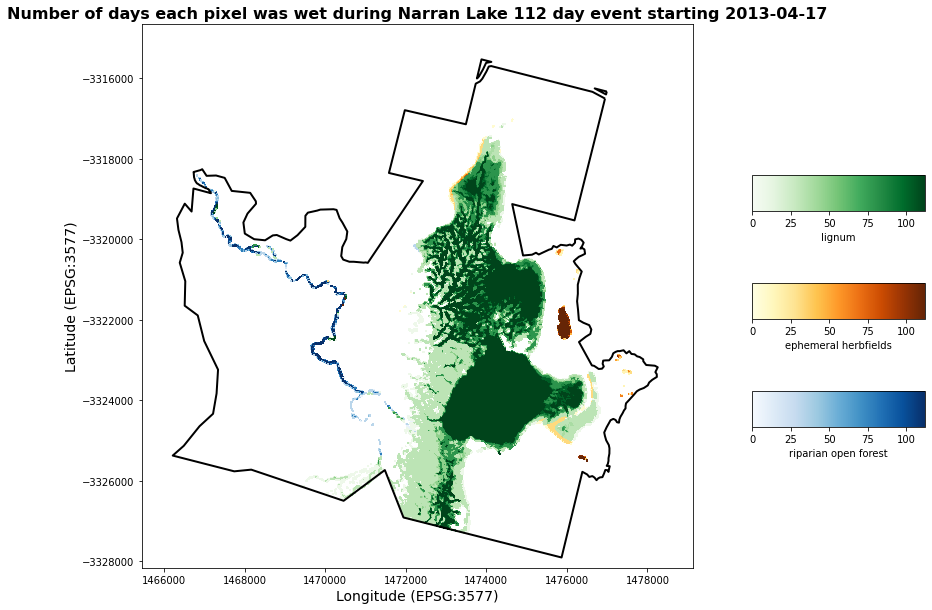

In [26]:
fig, ax = plt.subplots(1,1, figsize=[12, 10]);
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
AxLocation = 0.17;
fig.subplots_adjust(right=0.8);
for ix, items in enumerate(SpeciesDict):
    PlotData = EventResults.copy();
    PlotData[AllDataCombined['veg_randomUID'] != items] = np.nan;
    h = ax.pcolormesh(AllDataCombined.x, AllDataCombined.y, PlotData, cmap=Colormaps[ix], vmin=0, vmax=np.nanmax(EventResults));
    AxLocation = AxLocation + 0.15;
    # add_axes([left, bottom, width, height])
    cbar_ax = fig.add_axes([0.85, AxLocation, 0.2, 0.05]);
    fig.colorbar(h, cax=cbar_ax, label=SpeciesDict[items], orientation='horizontal');
ax.ticklabel_format(useOffset=False, style='plain');
ax.set_ylabel('Latitude (EPSG:3577)', fontsize=14);
ax.set_xlabel('Longitude (EPSG:3577)', fontsize=14);
ax.set_title(f'Number of days each pixel was wet during {AnalysisLocation} {row["days-in-event"]} day event starting {row["event-start-date"]}', 
             fontsize=16, fontweight='bold');

### 2.a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 

(NSW only)

## 3. Maps of depth for critical durations

Only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)

## 4. Vegetation condition over the entire four year period

## 5. Graph and .csv file of inundation duration for each different vegetation type
For all natural and environmental flows

### Read in the relevant stream gauge

Convert the timestamp to a pandas datetime object

In [25]:
# Read in the relevant streamgauge data
StreamGaugeData = pd.read_csv(StreamGaugeToLoad, parse_dates=True, comment='#')
# Turn the Timestamp into a padas dateime object
StreamGaugeData['Timestamp'] = pd.to_datetime(StreamGaugeData['Timestamp'])

### Calculate the percentage of each vegetation community inundated across all time

# We also want to know how big an area each vegetation community covers to put the percentages into perspective

In [26]:
# Create a dataframe to put our results into, starting with the time
InundationPctPerVeg = pd.DataFrame({'Date': AllDataCombined.time})
# Make the time the index for the dataframe
InundationPctPerVeg.set_index('Date', inplace=True)

# Loop through all the vegetation communities
for items in SpeciesDict:
    # Grab just the pixels containing our veg community
    WetVeg = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
    # Count the number of wet observations per time step
    WetVegCount = WetVeg.sum(dim=['x', 'y'])
    # Convert the count to a percentage of the total community that's wet
    WetVegPct = (WetVegCount / (AllDataCombined['veg_randomUID'] == items).sum()) * 100
    InundationPctPerVeg[SpeciesDict[items]] = WetVegPct

### Save the results to csv, and plot against the stream gauge

In [27]:
InundationPctPerVeg.to_csv(InundationPctPerVegDataFileName)

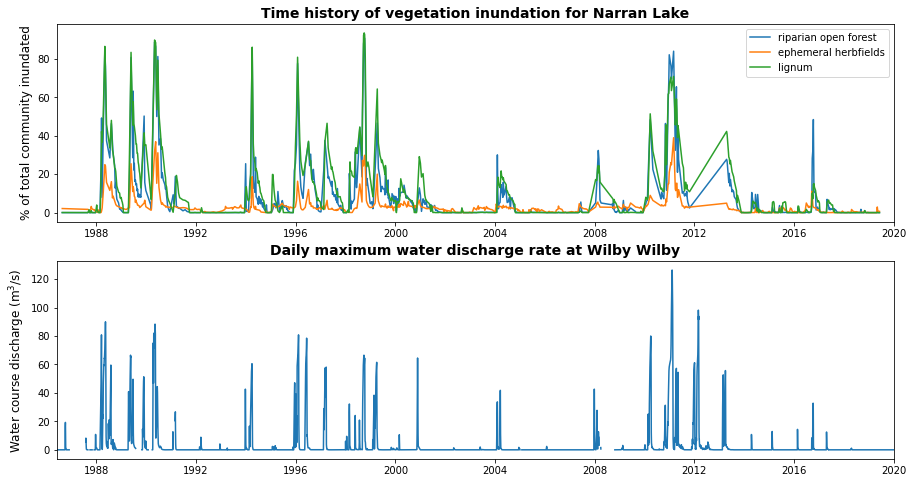

In [28]:
fig, axes = plt.subplots(2,1, figsize=(15,8));
axes[0].plot(InundationPctPerVeg);
axes[0].legend(InundationPctPerVeg.columns.values)
axes[0].set_ylabel(f'% of total community inundated', fontsize = 12);
axes[0].set_title(f'Time history of vegetation inundation for {AnalysisLocation}', fontsize = 14, fontweight = 'bold');
axes[0].set_xlim([pd.to_datetime('1986-6-1'), pd.to_datetime('2020-1-1')]);

axes[1].plot(StreamGaugeData['Timestamp'], StreamGaugeData['Value']);
axes[1].set_ylabel('Water course discharge (m$^3$/s)', fontsize = 12);
axes[1].set_title(f'Daily maximum water discharge rate at {StreamGaugeName}', fontsize = 14, fontweight = 'bold');
axes[1].set_xlim([pd.to_datetime('1986-6-1'), pd.to_datetime('2020-1-1')]);

plt.savefig(InundationPctPerVegFigFileName, bbox_inches='tight')

## 6. Table identifying: 
* % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.

e.g. 

| Site | Sub-site | Event | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|

* Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 

e.g.

| Site | Sub-site | Event | Vegetation Type | 10% veg inundation duration | 25% veg inundation duration | 50% veg inundation duration | 75% veg inundation duration | 100% veg inundation duration | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|

### Calculate within event inundation metrics

We need to set up two dataframes to put the results into

In [27]:
# Create a dataframe to put our results into, starting with the time
EventInundationTable = pd.concat([EventList]*len(SpeciesDict)).sort_values(by='event-start-date', ignore_index=True)
EventInundationTable['vegType'] = list(SpeciesDict.values())* len(EventList)
EventInundationTable['PctInundated>=30days'] = np.nan
EventInundationTable['PctInundated>=90days'] = np.nan
EventInundationTable['PctInundated>=150days'] = np.nan
EventInundationTable['PctInundated>=210days'] = np.nan
EventInundationTable['PctInundated>=270days'] = np.nan

In [28]:
EventInundationTable.head(2)

,days-in-event,event-start-date,event-end-date,vegType,PctInundated>=30days,PctInundated>=90days,PctInundated>=150days,PctInundated>=210days,PctInundated>=270days
0,231,1988-03-10,1988-10-27,riparian open forest,NaN,NaN,NaN,NaN,NaN
1,231,1988-03-10,1988-10-27,ephemeral herbfields,NaN,NaN,NaN,NaN,NaN


In [29]:
# Create a dataframe to put our results into, starting with the time
EventDurationTable = pd.concat([EventList]*len(SpeciesDict)).sort_values(by='event-start-date', ignore_index=True)
EventDurationTable['vegType'] = list(SpeciesDict.values())* len(EventList)
EventDurationTable['AtLeast10PctInundated'] = np.nan
EventDurationTable['AtLeast25PctInundated'] = np.nan
EventDurationTable['AtLeast50PctInundated'] = np.nan
EventDurationTable['AtLeast75PctInundated'] = np.nan
EventDurationTable['100PctInundated'] = np.nan

In [30]:
EventDurationTable.head(2)

,days-in-event,event-start-date,event-end-date,vegType,AtLeast10PctInundated,AtLeast25PctInundated,AtLeast50PctInundated,AtLeast75PctInundated,100PctInundated
0,231,1988-03-10,1988-10-27,riparian open forest,NaN,NaN,NaN,NaN,NaN
1,231,1988-03-10,1988-10-27,ephemeral herbfields,NaN,NaN,NaN,NaN,NaN


### Now calculate the % inundation and duration of each vegetation category per event

Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 

The second step in the analysis calculates how long at least 10/25/50/75/100% of the wetland vegetation community was inundated per event. We sort all of the values for each pixel in each event, and then use indexing to find the value at each percentage category. E.g.

```
EventResults = [0, 0, 6, 9, 4, 3, 0, 1, 1, 0]
TotalArraySize = len(EventResults)
SortedResults = [0, 0, 0, 0, 1, 1, 3, 4, 6, 9]
SortedResults = SortedResults[::-1] #reverse the order to descending
# Find the index of the value at 50% of the array ( - 1 due to zero indexing)
Indexat50PctArea = int(TotalArraySize * 0.5) -1
# The value in the sorted array at this index tells us how many days at least 50% of the veg area was wet for
AtLeast50PctofArray = SortedResults[Indexat50PctArea]
    >> 1
```

In [31]:
filelist = glob.glob(f'{EventResultsPickleFileName}*')
for files in filelist:
    with open(files,'rb') as f:
        EventResults = pickle.load(f)
    pathstartdate, vegname, items, analysisloc = files.split('_')
    pathbits = pathstartdate.split('/')
    startdate = pathbits[-1]
    # Now write out the inundation area percentage thresholds
    # Get the index of the row we need to put the results into
    indexofrow = EventInundationTable.loc[(EventInundationTable['event-start-date'] == startdate) 
                         & (EventInundationTable['vegType'] == SpeciesDict[int(items)])].index.item()
    # In the next lines, we are looking for locations in the results where values are >= some number
    # Since we have nans in the array, the code throws a warning
    # The behaviour of the comparison is correct for what we want, i.e. (NaN >= 30) = False
    # So we can suppress these warnings to clear up the output of this cell
    with np.errstate(invalid='ignore'):
        # Calculate the percent of each vegetation community inundated for the various lengths of time
        # Save out the results to one decimal place
        EventInundationTable.at[indexofrow,'PctInundated>=30days'] = round((((EventResults >=30).sum() / 
                                                                      (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=90days'] = round((((EventResults >=90).sum() / 
                                                                      (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=150days'] = round((((EventResults >=150).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=210days'] = round((((EventResults >=210).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
        EventInundationTable.at[indexofrow,'PctInundated>=270days'] = round((((EventResults >=270).sum() / 
                                                                       (AllDataCombined['veg_randomUID'] == int(items)).sum().item()) * 100), 1)
    # Now write out the inundation duration percentage thresholds
    # Get the index of the row we need to put the results into
    indexofrow = EventDurationTable.loc[(EventDurationTable['event-start-date'] == startdate) 
                         & (EventDurationTable['vegType'] == SpeciesDict[int(items)])].index.item()
    # Create a mask for the full extent of the vegetation category
    VegMask = AllDataCombined['veg_randomUID'] == int(items)
    # Work out the total number of pixels taken up by the veg category
    VegTotalArea = VegMask.sum().item()
    # Convert all the nans in the EventResults to zero
    # This is because we want to know where a veg pixel was not seen as wet at all
    InfilledEventResults = np.nan_to_num(EventResults)
    # Remove the zeros from EventResults that are not covered by the veg category
    InfilledEventResults[~VegMask] = np.nan
    # Flatten the results - we don't need them to be spatial anymore
    AllFiniteValues = InfilledEventResults.flatten()
    # Remove all the nans - they're outside the area of interest
    AllFiniteValues = AllFiniteValues[~np.isnan(AllFiniteValues)]
    # Sort the array
    AllFiniteValuesSorted = np.sort(AllFiniteValues)
    # Reverse the order
    AllFiniteValuesSorted = AllFiniteValuesSorted[::-1]
    # Find the value in the sorted array that cuts off 10/25/50/75/100% of the array
    # Subtract one from the index due to zero indexing
    EventDurationTable.at[indexofrow,'AtLeast10PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[0] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast25PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[1] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast50PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[2] -1)], 1)
    EventDurationTable.at[indexofrow,'AtLeast75PctInundated'] = round(AllFiniteValuesSorted[int(VegTotalArea * AreasToCalc[3] -1)], 1)
    # 100% of the array is the last value, so just grab that
    EventDurationTable.at[indexofrow,'100PctInundated'] = round(AllFiniteValuesSorted[VegTotalArea * AreasToCalc[4] -1], 1)

    # Save the final tables to file
    EventInundationTable.to_csv(EventInundationTableFileName, index=False)
    EventDurationTable.to_csv(EventDurationTableFileName, index=False)

## 7. Annual vegetation condition for each Ramsar site for the whole archive period

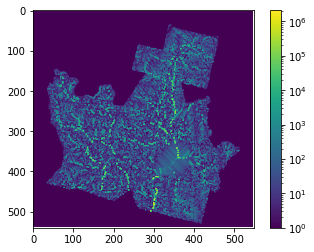

In [67]:
plt.imshow(AllDataCombined.DEMAcc, norm=mpl.colors.LogNorm() )
plt.colorbar()